## Imports, Data

In [1]:
import pandas as pd
import re

import matplotlib.pyplot as plt

In [2]:
import sys 
import os
sys.path.append(os.path.abspath("../src"))

import functions as fnc

In [3]:
data = pd.read_csv('../data/titanic/train.csv')
data_test = pd.read_csv('../data/titanic/test.csv')

In [4]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
data_dict = {}
data_dict['categorical'] = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked']
data_dict['continuous'] = ['Age', 'Fare']
data_dict['other'] = ['Name', 'Cabin', 'Ticket']

## Checking the data
it is extremely important to understand the dataset that you are working with, for a few reasons.

1) detect any issues with the data collection, selection, filtering etc.

2) find any issues within the data such as missing information.

3) find any useful trends that may influence how you tackle the problem (e.g. do we have two sub-populations that we want to treat differently.

### overview of categorical data

In [6]:
for cat in data_dict['categorical']:
    display(data[cat].value_counts(dropna = False))

3    491
1    216
2    184
Name: Pclass, dtype: int64

male      577
female    314
Name: Sex, dtype: int64

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [7]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We have missing entries for age, cabin and Embarked. Given that we are going to be using XGBoost this is not too much of an issue, however it is important to decide if there is some issue with the way that the data was collected, such that one group of people are missing but others are not. this may then affect how we treat these missing values (e.g. perhaps we want to replace with the mean value for that group of people, rather than the overall mean)


### categorical overview

,n_positive,n_records,rate
Pclass,,,
1,136,216,62.962963
2,87,184,47.282609
3,119,491,24.236253


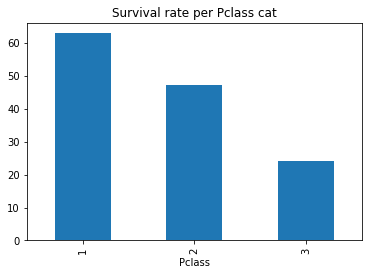

,n_positive,n_records,rate
Sex,,,
female,233,314,74.203822
male,109,577,18.890815


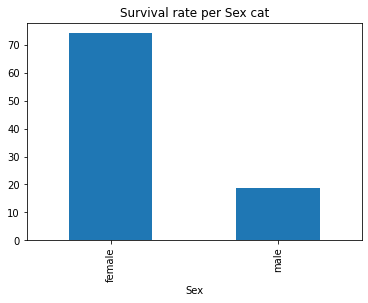

,n_positive,n_records,rate
SibSp,,,
0,210,608,34.539474
1,112,209,53.588517
2,13,28,46.428571
3,4,16,25.000000
4,3,18,16.666667
5,0,5,0.000000
8,0,7,0.000000


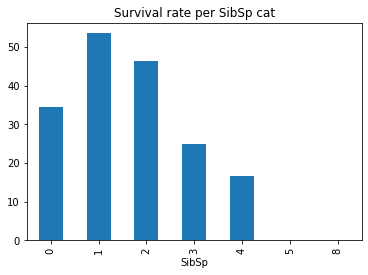

,n_positive,n_records,rate
Parch,,,
0,233,678,34.365782
1,65,118,55.084746
2,40,80,50.000000
3,3,5,60.000000
4,0,4,0.000000
5,1,5,20.000000
6,0,1,0.000000


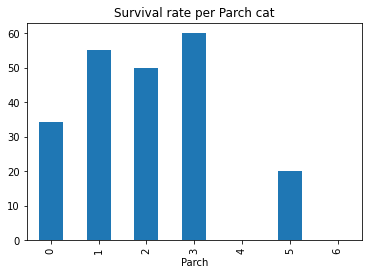

,n_positive,n_records,rate
Embarked,,,
C,93,168,55.357143
Q,30,77,38.961039
S,217,644,33.695652


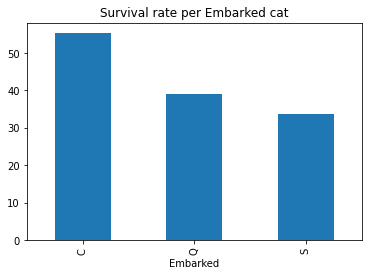

In [8]:
for c in data_dict['categorical']:
    summy = fnc.badrate_summary_categories(data, c, 'Survived')
    display(summy)
    summy['rate'].fillna(0).plot(kind='bar', title = 'Survival rate per {} cat'.format(c))
    plt.show()
    

In [9]:
(100* pd.crosstab(data['Pclass'], data['Sex'] ,values= data['Survived'], aggfunc = 'sum') / pd.crosstab(data['Pclass'], data['Sex'] )).style.set_caption('We can see that if you are female you have a significantly higher chance of surviving. If you are female and in the two upper classes, you are extremely likely to survive.').background_gradient(axis= None).format("{:.2f}%")

Sex,female,male
Pclass,,
1,96.81%,36.89%
2,92.11%,15.74%
3,50.00%,13.54%


### investigating missing ages

,n_positive,n_records,rate
Pclass,,,
1,30,216,13.888889
2,11,184,5.978261
3,136,491,27.698574


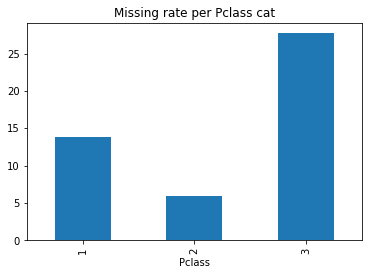

,n_positive,n_records,rate
Sex,,,
female,53,314,16.878981
male,124,577,21.490468


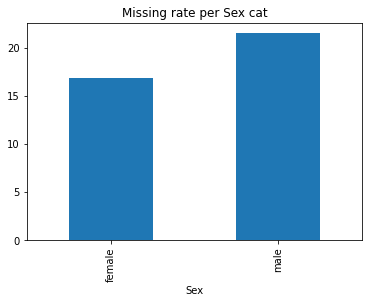

,n_positive,n_records,rate
SibSp,,,
0,137,608,22.532895
1,26,209,12.440191
2,3,28,10.714286
3,4,16,25.000000
4,0,18,0.000000
5,0,5,0.000000
8,7,7,100.000000


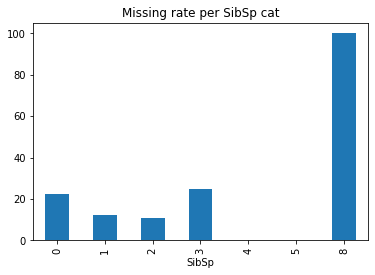

,n_positive,n_records,rate
Parch,,,
0,157,678,23.156342
1,8,118,6.779661
2,12,80,15.000000
3,0,5,0.000000
4,0,4,0.000000
5,0,5,0.000000
6,0,1,0.000000


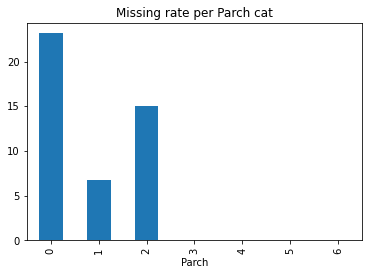

,n_positive,n_records,rate
Embarked,,,
C,38,168,22.619048
Q,49,77,63.636364
S,90,644,13.975155


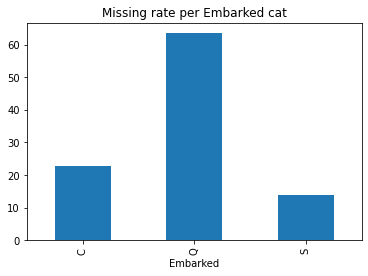

In [10]:
data['J_missing_age'] = 0
data.loc[data['Age'].isnull(), 'J_missing_age'] = 1

for c in data_dict['categorical']:
    summy = fnc.badrate_summary_categories(data, c, 'J_missing_age')
    display(summy)
    summy['rate'].fillna(0).plot(kind='bar', title = 'Missing rate per {} cat'.format(c))
    plt.show()

we can see a few things:
1) the largest issue is with people embarking in Q

2) people in the worst class are significantly more likely to have a missing age

### overview of continuous data

we can see the very youngest passangers are highly likely to survive, likely due to being prioritised for lifeboats. 

We can also see that passangers that paid a higher fare are much more likely to survive

#### age

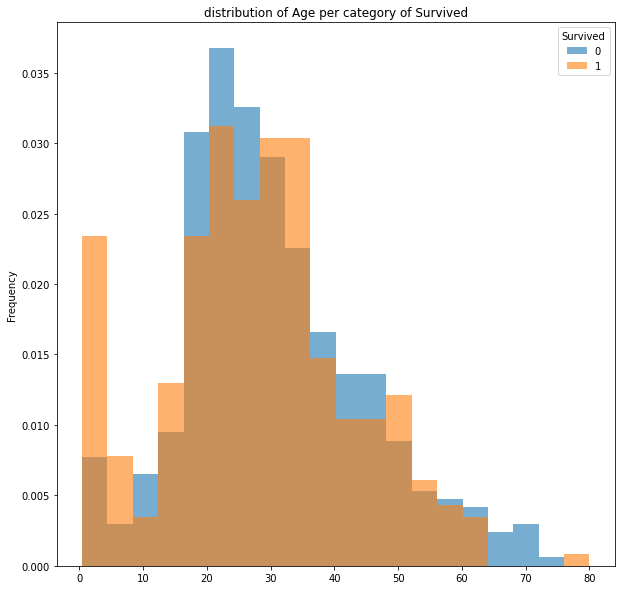

In [11]:
fnc.plot_distro_per_cat(data,'Age','Survived', plt_args = {'bins':20, 'alpha': 0.6, 'density': True}, figsize=(10,10))

#### fare

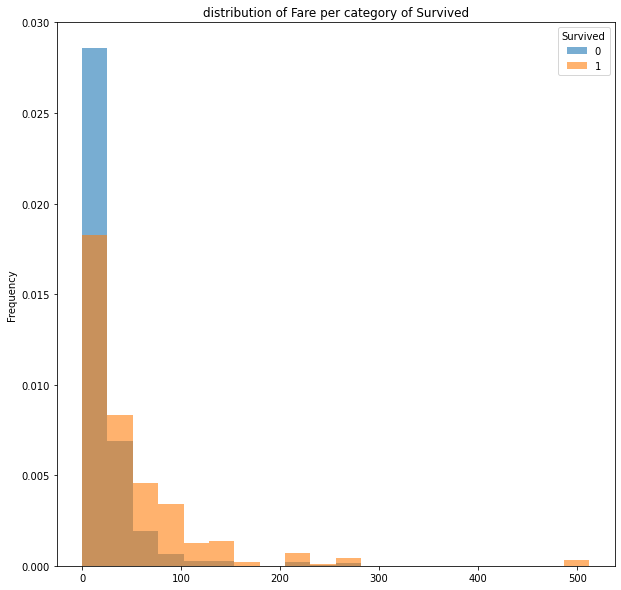

In [12]:
fnc.plot_distro_per_cat(data,'Fare','Survived', plt_args = {'bins':20, 'alpha': 0.6, 'density': True}, figsize=(10,10))

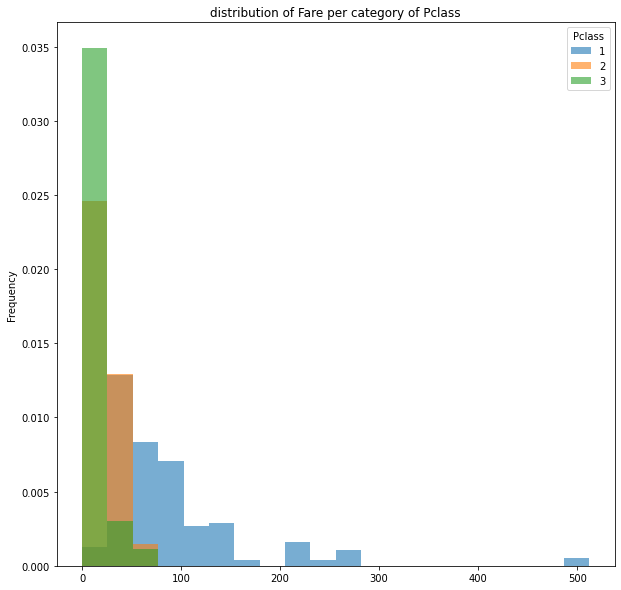

In [13]:
fnc.plot_distro_per_cat(data,'Fare','Pclass', plt_args = {'bins':20, 'alpha': 0.6, 'density': True}, figsize=(10,10))

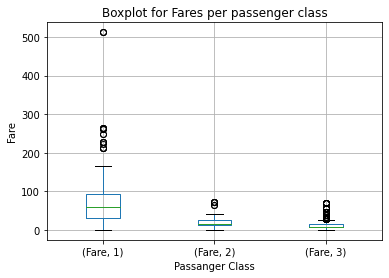

In [14]:
data.loc[:,['Fare', 'Pclass']].pivot(columns='Pclass').boxplot( );
plt.ylabel('Fare');
plt.xlabel('Passanger Class');
plt.title('Boxplot for Fares per passenger class');
plt.show()

In [15]:
data['J_age_binned'], age_bins = pd.qcut(data['Age'], 10, retbins = True)
data['J_age_binned'] = data['J_age_binned'].values.add_categories('MISSING')
data['J_age_binned'] = data['J_age_binned'].fillna('MISSING')
data['J_fare_binned'], fare_bins = pd.qcut(data['Fare'], 10, retbins=True)


,n_positive,n_records,rate
J_age_binned,,,
"(0.419, 14.0]",45,77,58.441558
"(14.0, 19.0]",34,87,39.080460
"(19.0, 22.0]",19,67,28.358209
"(22.0, 25.0]",26,70,37.142857
"(25.0, 28.0]",24,61,39.344262
"(28.0, 31.8]",26,66,39.393939
"(31.8, 36.0]",44,91,48.351648
"(36.0, 41.0]",19,53,35.849057
"(41.0, 50.0]",31,78,39.743590


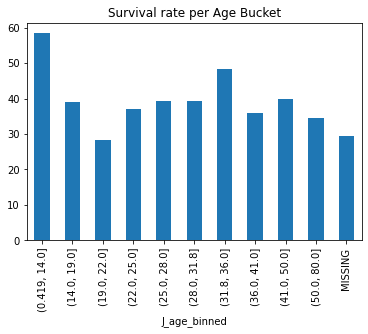

In [16]:
summy = fnc.badrate_summary_categories(data, 'J_age_binned', 'Survived')
display(summy)
summy['rate'].fillna(0).plot(kind='bar', title = 'Survival rate per Age Bucket')
plt.show()

In [17]:
(100* pd.crosstab(data['J_age_binned'], data['Sex'] ,values= data['Survived'], aggfunc = 'sum') / pd.crosstab(data['J_age_binned'], data['Sex'] )).style.set_caption('We continue to see the huge gender disparity when comparing with age. Interesting that old women have similar or higher survival rates to the younger ones. ').background_gradient(axis= None).format("{:.2f}%")

Sex,female,male
J_age_binned,,
"(0.419, 14.0]",63.16%,53.85%
"(14.0, 19.0]",78.38%,10.00%
"(19.0, 22.0]",66.67%,10.87%
"(22.0, 25.0]",76.92%,13.64%
"(25.0, 28.0]",72.22%,25.58%
"(28.0, 31.8]",73.08%,17.50%
"(31.8, 36.0]",96.55%,25.81%
"(36.0, 41.0]",68.18%,12.90%
"(41.0, 50.0]",70.37%,23.53%


## playing with the Name column

In [18]:
name_df = fnc.process_name(data)
data['J_title_grouped'] = name_df['J_title_grped']
data['J_nrelatives'] = name_df['J_nrelatives']

In [19]:
name_df = fnc.process_name(data_test)
data_test['J_title_grouped'] = name_df['J_title_grped']
data_test['J_nrelatives'] = name_df['J_nrelatives']

In [20]:
# where can you find people with each title? 
100*pd.crosstab(data['J_title_grouped'], data['Pclass']).div(pd.crosstab(data['J_title_grouped'], data['Pclass']).sum(axis=1), axis=0).round(2)

Pclass,1,2,3
J_title_grouped,,,
Master,8.0,22.0,70.0
Miss,26.0,19.0,55.0
Mr,21.0,18.0,62.0
Mrs,34.0,33.0,33.0
Nobility/Job Prefix,64.0,36.0,0.0


In [21]:
# are larger groups found in worse classes?
display(pd.crosstab(data['J_nrelatives'], data['Pclass']))
100*pd.crosstab(data['J_nrelatives'], data['Pclass']).div(pd.crosstab(data['J_nrelatives'], data['Pclass']).sum(axis=1), axis=0).round(2)

Pclass,1,2,3
J_nrelatives,,,
0,132,111,291
1,47,37,82
2,21,21,42
3,12,13,31
4,0,0,5
5,4,2,24
6,0,0,7
8,0,0,9


Pclass,1,2,3
J_nrelatives,,,
0,25.0,21.0,54.0
1,28.0,22.0,49.0
2,25.0,25.0,50.0
3,21.0,23.0,55.0
4,0.0,0.0,100.0
5,13.0,7.0,80.0
6,0.0,0.0,100.0
8,0.0,0.0,100.0


## playing with Ticket column

In [22]:
ticket_info = fnc.process_Ticket(data)
ticket_info    

,raw,prefix,ticket_number,J_prefix,J_ticket_location
0,A/5 21171,A/5,21171,A5,
1,PC 17599,PC,17599,PC,
2,STON/O2. 3101282,STON/O2,3101282,O2,southampton
3,113803,NO_PREFIX,113803,NO_PREFIX,
4,373450,NO_PREFIX,373450,NO_PREFIX,
...,...,...,...,...,...
886,211536,NO_PREFIX,211536,NO_PREFIX,
887,112053,NO_PREFIX,112053,NO_PREFIX,
888,W./C. 6607,W/C,6607,WC,
889,111369,NO_PREFIX,111369,NO_PREFIX,


In [23]:
data['J_ticket_prefix'] = ticket_info['J_prefix']
data['J_ticket_number'] = ticket_info['ticket_number']
data['J_ticket_location'] = ticket_info['J_ticket_location']

In [24]:
ticket_info = fnc.process_Ticket(data_test)
data_test['J_ticket_prefix'] = ticket_info['J_prefix']
data_test['J_ticket_number'] = ticket_info['ticket_number']
data_test['J_ticket_location'] = ticket_info['J_ticket_location']

## playing with cabin

In [25]:
data = fnc.process_cabin(data)

In [26]:
data_test = fnc.process_cabin(data_test)

In [27]:
data = fnc.process_siblings_spouses(data)

data_test= fnc.process_siblings_spouses(data_test)

In [28]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,J_age_binned,J_fare_binned,J_title_grouped,J_nrelatives,J_ticket_prefix,J_ticket_number,J_ticket_location,J_cabin_letter,J_room_number,J_n_siblings_spouses
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,"(19.0, 22.0]","(-0.001, 7.55]",Mr,1,A5,21171,,MISSING,,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,"(36.0, 41.0]","(39.688, 77.958]",Mrs,0,PC,17599,,C,85,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,"(25.0, 28.0]","(7.854, 8.05]",Miss,0,O2,3101282,southampton,MISSING,,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,"(31.8, 36.0]","(39.688, 77.958]",Mrs,1,NO_PREFIX,113803,,C,123,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,"(31.8, 36.0]","(7.854, 8.05]",Mr,1,NO_PREFIX,373450,,MISSING,,0


In [29]:
if not os.path.exists('../data/processed'):
    os.mkdir('../data/processed')

In [30]:
data['J_age_binned'] = data['J_age_binned'].astype(str)
data['J_fare_binned'] = data['J_fare_binned'].astype(str)

In [31]:
data['died'] = 0
data.loc[data['Survived']==0, 'died'] = 1

In [32]:
data.to_csv('../data/processed/train.csv', index=False)
data_test.to_csv('../data/processed/test.csv', index=False)